Two primitives to work with data: torch.utils.data.Dataloader and torch.utils.Dataset

Dataset stores the samples and corresponding labels, Dataloader wraps an iterable around the dataset

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

Offers torchtext, torchvision, and torchaudio

torchvision.datasets contain Dataset objects for real world vision
Transform (modifies the samples), target transform modifies the labels

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


Pass dataset as argument to dataloader. Wraps iterable over dataset and supports automatic batching, sampling, shuffling and multiprocess data loading

In [3]:
#Each element in dataloader iterable will return batch of 64 features and labels
batch_size=64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

#Look into this more
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


To define neural network in pytorch, create class inherting from nn.Module
Layers of network in __init__ function, specify how layers pass through the network in the forward function

In [4]:
device = "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Need loss function and optimizer to train a model

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
---------------------------
loss: 2.299927 [   64/60000]
loss: 2.290554 [ 6464/60000]
loss: 2.272920 [12864/60000]
loss: 2.269971 [19264/60000]
loss: 2.247929 [25664/60000]
loss: 2.228224 [32064/60000]
loss: 2.236415 [38464/60000]
loss: 2.205020 [44864/60000]
loss: 2.200093 [51264/60000]
loss: 2.169272 [57664/60000]
Test Error: 
 Accuracy: 40.2%, Avg loss: 2.164590 

Epoch 2
---------------------------
loss: 2.171118 [   64/60000]
loss: 2.163300 [ 6464/60000]
loss: 2.108594 [12864/60000]
loss: 2.125295 [19264/60000]
loss: 2.075320 [25664/60000]
loss: 2.018136 [32064/60000]
loss: 2.045890 [38464/60000]
loss: 1.971141 [44864/60000]
loss: 1.979437 [51264/60000]
loss: 1.906013 [57664/60000]
Test Error: 
 Accuracy: 54.4%, Avg loss: 1.906195 

Epoch 3
---------------------------
loss: 1.934625 [   64/60000]
loss: 1.907697 [ 6464/60000]
loss: 1.795442 [12864/60000]
loss: 1.831597 [19264/60000]
loss: 1.731190 [25664/60000]
loss: 1.673362 [32064/60000]
loss: 1.700155 [38464/60000]
loss:

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved Pytorch Model State to model.pth")

Saved Pytorch Model State to model.pth


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Tensors are specialized data structures similar to arrays and matrices. Use tensors to encode inputs and outputs of a model and the model's parameters. 

Can run on GPUs or other hardware accelerators, share underlying memory with NumPy. Can optimize for automatic differentiation.

In [12]:
import torch
import numpy as np

In [13]:
#initializing tensor
data = [[1,2],[3,4]]
x_data = torch.tensor(data)

In [14]:
#can be initialized from numpy arrays
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [15]:
#retains properties of argument tensor unless overridden
x_ones = torch.ones_like(x_data)
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float)
print(f"Random Tensor: \n {x_rand} \n")



Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.5021, 0.9237],
        [0.1045, 0.4445]]) 



In [16]:
#Shape is a tuple of tensor dimensions, dimensionality of the output tensor
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor} \n")


Random Tensor: 
 tensor([[0.6833, 0.1776, 0.1089],
        [0.5026, 0.8643, 0.4436]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]]) 



In [17]:
#attributes: shape, datatype, and device they are stored
tensor = torch.rand(3,4)
print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [18]:
#standard numpy like:
tensor = torch.ones(4,4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:,0]}")
print(f"Last column: {tensor[:,-1]}")
tensor[:,1]=0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [19]:
#Joining tensors through cat
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [20]:
#arithmetic operations
#matrix multiplication
y1 = tensor @ tensor.T
print(y1)
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)

#computes element-wise product
z1 = tensor * tensor
z2 = tensor.mul(tensor)
z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [21]:
#Single element tensors: aggregating all values of a tensor into one value
agg = tensor.sum()
print(agg)
agg_item = agg.item()
print(agg_item, type(agg_item))

tensor(12.)
12.0 <class 'float'>


In [22]:
#in-place operand
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


In [23]:
#tensor to numpy
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [24]:
#changes reflect in numpy array
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


In [25]:
#numpy to tensor
n = np.ones(5)
t = torch.from_numpy(n)
print(f"n: {n}")
print(f"t: {t}")

n: [1. 1. 1. 1. 1.]
t: tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


In [26]:
np.add(n, 1, out=n)
print(f"n: {n}")
print(f"t: {t}")

n: [2. 2. 2. 2. 2.]
t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


Data samples messy, want our dataset decoupled from our model training code. DataLoader (wraps an iterable around dataset for easy access to samples) and Dataset (stores samples and corresponding labels).

In [27]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data", #path where data is stored
    train = True, #training or test dataset
    download = True, #downloads data from internet if not available at root
    transform = ToTensor() #feature and label transformations
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = ToTensor()
)

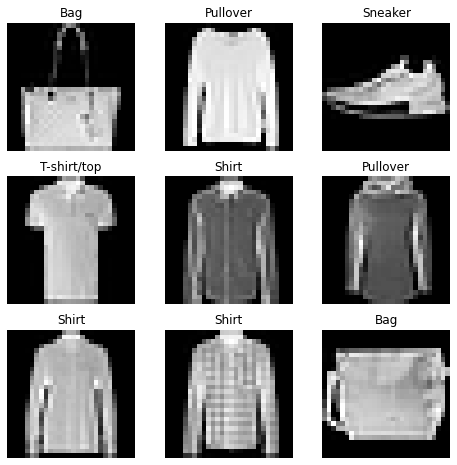

In [28]:
#Iterating and Visualizing Dataset
labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Custom dataset implements init, len and, getitem. FashionMNIST images are stored in directory img_dir and labels are stored separately in a CSV file annotations_file

In [29]:
import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    #instantiating the dataset object
    #
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    #returns number of samples in our dataset
    def __len__(self):
        return len(self.img_labels)
    
    #loads and returns a sample from a dataset at given index
    #identifies location on disk, converts to tensor (decode image), and retrieves the label
    #Calls transform funcs and returns tensor image and corresponding label
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Preparing your data for training with DataLoaders.
Dataloader is an iterable, can do minibatches, and reshuffles the data at every epoch to reduce model overfitting and use multiprocessing

In [30]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Can iterate through dataset as needed. Each iteration returns a batch of train_features and train_labels (containing batch_size 64).
After we iterate over all batches the data is shuffled

Featrue batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


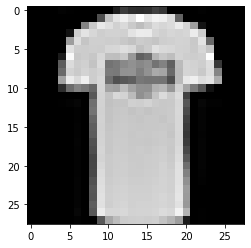

Label: 0


In [31]:
#Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Featrue batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Transforms perform some data manipulation.
Transform modifies the features, target_transform modifies the labels
Features are in PIL image format, labels are integers
Features need to be normalized tensors and labels need to be one-hot encoded tensors

In [32]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

ToTensor converts PIL image or NumPy array to float tensor and scales image's pixel values in range [0,1].
Lambda transforms apply user-defined lambda function. 
Function turns the integer to a one hot encoded tensor (zero tensor of size 10 -- # of labels, then assigns a value of 1 on the index as given bu label y

Building the Neural Network: layers/modules that perform operations on data. Torch.nn provides building blocks to build your own neural network. 

In [33]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [34]:
device = "cpu"
print(f"Using {device} device")

Using cpu device


Subclass nn.Modue, initialize neural network, implements operations on input data in the forward method

In [35]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [36]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Pass the input data, executes model's forward along with background operations. Returns 2-dim tensor of 10 raw predicted values for each class and individual values of each output. nn.Softmax gets the prediction probabilities

In [37]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
# print(pred_probab)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0])


nn.flatten layer converts each 2D 28x28 image to a contiguous array of 784 pixel values

In [38]:
input_image = torch.rand(3,28,28)
print(input_image.size())
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 28, 28])
torch.Size([3, 784])


In [39]:
print(input_image)
print(flat_image)

tensor([[[0.1499, 0.5128, 0.3023,  ..., 0.7438, 0.5144, 0.0647],
         [0.5940, 0.9664, 0.5005,  ..., 0.4283, 0.0769, 0.9604],
         [0.4170, 0.2685, 0.9758,  ..., 0.3078, 0.4443, 0.8328],
         ...,
         [0.9465, 0.8249, 0.6175,  ..., 0.8987, 0.8608, 0.1648],
         [0.2552, 0.9921, 0.6825,  ..., 0.2603, 0.0881, 0.9165],
         [0.0665, 0.3422, 0.7365,  ..., 0.9755, 0.1568, 0.5573]],

        [[0.5317, 0.6538, 0.7180,  ..., 0.3585, 0.6543, 0.3792],
         [0.9606, 0.6672, 0.4040,  ..., 0.3308, 0.0029, 0.7779],
         [0.6311, 0.1739, 0.1552,  ..., 0.0173, 0.9917, 0.9019],
         ...,
         [0.8427, 0.6045, 0.4019,  ..., 0.4433, 0.2986, 0.9957],
         [0.3963, 0.3576, 0.0623,  ..., 0.2409, 0.5728, 0.7739],
         [0.1775, 0.9295, 0.2069,  ..., 0.2185, 0.1904, 0.5429]],

        [[0.3921, 0.8695, 0.6725,  ..., 0.1988, 0.6637, 0.9307],
         [0.5682, 0.0694, 0.8414,  ..., 0.1541, 0.1740, 0.1050],
         [0.4729, 0.0505, 0.0105,  ..., 0.9993, 0.9126, 0.

linear layer applies a linear transformation on input using stored weights and biases

In [40]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


Non-linear activations create complex mappings between model's inputs and outputs. Introduce nonlinearity

In [41]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.2357,  0.4367, -0.4475,  0.1966, -0.0390, -0.0804, -0.0255, -0.2463,
          0.1718, -0.1379, -0.9255, -0.3986, -0.0055,  0.3634, -0.0408, -0.3125,
         -0.0836,  0.2721,  0.1517, -0.4176],
        [-0.1885,  0.4156, -0.3293,  0.0895,  0.1444, -0.1808,  0.0825, -0.2913,
         -0.0957,  0.0867, -0.7684, -0.5227,  0.2723,  0.2543,  0.0174, -0.0996,
         -0.0882,  0.2158,  0.0828, -0.6404],
        [-0.4000,  0.3350, -0.5802, -0.0096,  0.1796, -0.0468, -0.2470, -0.4162,
          0.1221, -0.1807, -1.1182, -0.2311, -0.0764,  0.4609,  0.0201, -0.0798,
         -0.0342,  0.6605,  0.1112, -0.5658]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.4367, 0.0000, 0.1966, 0.0000, 0.0000, 0.0000, 0.0000, 0.1718,
         0.0000, 0.0000, 0.0000, 0.0000, 0.3634, 0.0000, 0.0000, 0.0000, 0.2721,
         0.1517, 0.0000],
        [0.0000, 0.4156, 0.0000, 0.0895, 0.1444, 0.0000, 0.0825, 0.0000, 0.0000,
         0.0867, 0.0000, 0.0000, 0.2723, 0.2543, 0.01

nn.Sequential os ordered container of modules, data passed through all modules in same order as defined (put together a quick network like seq_modules)

In [42]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20,10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)
print(logits)

tensor([[-0.3472, -0.1560,  0.0596, -0.2420,  0.0865, -0.3657, -0.0122, -0.1738,
          0.0249, -0.2875],
        [-0.1635, -0.1849,  0.0839, -0.1666,  0.1703, -0.2322, -0.0559, -0.1043,
         -0.0092, -0.1570],
        [-0.1896, -0.1388,  0.0671, -0.0317,  0.2700, -0.1053, -0.0228, -0.2569,
          0.0957, -0.3069]], grad_fn=<AddmmBackward0>)


Logits (raw values) passed to the nn.Softmax module, scaled to values [0,1]. represents the model's predicted probabilities for each class. Dim indicates which the values must sum to 1

In [43]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
print(pred_probab)

tensor([[0.0803, 0.0973, 0.1207, 0.0892, 0.1240, 0.0789, 0.1123, 0.0956, 0.1165,
         0.0853],
        [0.0915, 0.0895, 0.1171, 0.0912, 0.1277, 0.0854, 0.1018, 0.0970, 0.1067,
         0.0921],
        [0.0868, 0.0913, 0.1122, 0.1016, 0.1374, 0.0944, 0.1025, 0.0811, 0.1154,
         0.0772]], grad_fn=<SoftmaxBackward0>)


In [44]:
np.sum([0.0922, 0.0911, 0.1162, 0.0733, 0.1132, 0.1111, 0.1089, 0.0969, 0.0913,
         0.1058])

1.0

Many layers inside the neural network are parametrized (have associated weights and biases optimized during training)

In [45]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layers: {name} | Size: {param.size()} | Values: {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layers: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[ 0.0227, -0.0093,  0.0293,  ..., -0.0053,  0.0130, -0.0305],
        [ 0.0189, -0.0161, -0.0065,  ..., -0.0184,  0.0294,  0.0051]],
       grad_fn=<SliceBackward0>) 

Layers: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([-0.0335, -0.0162], grad_fn=<SliceBackward0>) 

Layers: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[ 0.0324,  0.0430, -0.0282,  ...,  0.0419,  0.0081,  0.0115],
        [-0.0016, -0.0421,  0.0084,  ...,  0.0375,  0.0352, -0.0406]],
       grad_fn=<SliceBackward0>) 

Layers: linear_relu_stack.2.bias |

Automatic differentiation with torch.autograd. When training neural networks, the most frequently used algorithm is back propagation. parameters (model weights) are adjusted according to the gradient of the loss function wrt a given parameter.
Torch.autograd is a built-in differentiation engine, supports automatic computation of gradient for any computational graph.

In [46]:
import torch
x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

w anb b are parameters we need to optimize, need to compute the gradients of the loss function wrt those variables (requires_grad property)

Function we apply to tensors to construct computational graph (object of class Function). Knows how to compute the function in the forward direction and how to compute its derivative during the backward propagation step (grad_fn)

In [47]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f9d61f0f5e0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f9d61f0f520>


Computing gradients: optimize weights of parameters in the neural network, compute derivatives of our loss function wrt parameters (w and b)

In [48]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3149, 0.1706, 0.2649],
        [0.3149, 0.1706, 0.2649],
        [0.3149, 0.1706, 0.2649],
        [0.3149, 0.1706, 0.2649],
        [0.3149, 0.1706, 0.2649]])
tensor([0.3149, 0.1706, 0.2649])


Disable Gradient tracking -- all tensors with requires_grad=True track their computational history and support gradient computation. Some cases when we do not need to do that, trained model and want to apply it with input data (only forward computations)

In [49]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [50]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


Disable gradient tracking to mark some parameters as frozen parameters, speed up computations

Autograds keep a record of data (tensors) and all executed operations in directed acyclic graph consisting of Function objects.
Automatically compte the gradients using the chain rule.

Forward pass: run the requested operation to compute a resulting tensor, maintain the operation's gradient function in DAG
Backward pass (.backward()): computes the gradients .grad_fn, accumulates them in the respective tensor's .grad attribute, propagates all the way to the leaf tensors using chaine rule

In some cases when output is a tensor, it allows you to compute a Jacobian product, not the actual gradient

In [52]:
inp = torch.eye(4, 5, requires_grad=True)
print(inp)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]], requires_grad=True)
First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Optimizing model parameter: train, validate and test our model by optimizing its parameters on our data

In [53]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()


Number of epochs: number of times to iterate over the dataset,
Batch size: number of data samples propagated through the network before the parameters are updated,
Learning rate: how much to update models parameters at each batch/epoch, smaller valies yield low learning speed, large values result in unpredictable behavior during training

In [54]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

train and optimize our model, each iteration of the optimization loop is called an epoch.
Train loop: iterate over the training dataset, try to converge optimal parameters
validation/test loop: iterate over the test dataset to check if model performance is improving

Loss function: training data, untrained network not likely to give the correct answer, loss function measures the degree of dissimilarity of obtained result to the target value (loss function we want to minimize during training),
Make a prediction using the inputs of our given data sample and compare it against the true data label value

loss_fn = nn.CrossEntropyLoss()

Optimization adjusts model parameters to reduce model error, initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter

In [55]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [56]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    #Set model to training mode – important for batch normalization and dropout layers
    #Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    #Set the model to evaluation mode – important for batch normalization and dropout layers
    #Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    
        
    

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
---------------------------
loss: 2.295537 [   64/60000]
loss: 2.288702 [ 6464/60000]
loss: 2.271168 [12864/60000]
loss: 2.271898 [19264/60000]
loss: 2.243320 [25664/60000]
loss: 2.234387 [32064/60000]
loss: 2.230345 [38464/60000]
loss: 2.195346 [44864/60000]
loss: 2.197858 [51264/60000]
loss: 2.182171 [57664/60000]
Test Error: 
 Accuracy: 49.2%, Avg loss: 2.163123

Epoch 2
---------------------------
loss: 2.170091 [   64/60000]
loss: 2.160707 [ 6464/60000]
loss: 2.103638 [12864/60000]
loss: 2.129666 [19264/60000]
loss: 2.064082 [25664/60000]
loss: 2.025938 [32064/60000]
loss: 2.044333 [38464/60000]
loss: 1.959679 [44864/60000]
loss: 1.978667 [51264/60000]
loss: 1.919747 [57664/60000]
Test Error: 
 Accuracy: 54.4%, Avg loss: 1.902406

Epoch 3
---------------------------
loss: 1.934423 [   64/60000]
loss: 1.905419 [ 6464/60000]
loss: 1.781344 [12864/60000]
loss: 1.835125 [19264/60000]
loss: 1.715710 [25664/60000]
loss: 1.675881 [32064/60000]
loss: 1.698755 [38464/60000]
loss: 1